<a href="https://colab.research.google.com/github/CFVV/MSc-assignments/blob/main/T1_Automatic_letter_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea 01: Reconocedor de Letras
## Curso Reconocimiento de Patrones

Departamento de Ciencia de la Computación

Pontificia Universidad Católica de Chile

Camila F. Vera Villa


#Descripción
El objetivo de esta tarea es diseñar y evaluar un reconocedor automático de las letras X, Y, Z, A, B, en diferentes fonts.


En esta tarea, se busca extraer características de estas letras de tal forma que se pueda diseñar un clasificador que reconozca de manera automática cuál de las cinco letras es. Para el clasificador se usará como conjunto de entrenamiento las primeras 75 imágenes de cada letra, y como conjunto de test las 25 imágenes restantes, son 100 en total.

# 0. Setup Inicial
Importación de librerías necesarias

In [ ]:
import numpy as np
import pandas as pd
import cv2 #!pip install opencv-python
import matplotlib.pyplot as plt
from   scipy.ndimage.morphology import binary_fill_holes
import seaborn as sns

# 1. Carga de datos
Hay 100 imágenes de cada una de las cinco letras X, Y, Z, A, B en diferentes fonts.


El formato del nombre de las imágenes es 'char_nn_kkk.png', donde nn = 01, ... 05, indica el numero de la letra (X,Y,Z,A,B respectivamente), y kkk = 001, 002, ... 100 indica el número de la imagen.

In [ ]:
# Descarga de la totalidad de las imágenes desde el GitHub del curso
!wget https://github.com/domingomery/patrones/blob/master/tareas/Tarea_01/letras.zip?raw=true letras.zip

In [ ]:
# Descomprimir la carpeta de imágenes
!unzip letras.zip?raw=true

In [ ]:
# Funciones necesarias para que se pueda cargar una imagen individual

def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix,num_char,num_img,echo='off'):
  # img = ImageLoad('example/char_',1,3)   loads image 'example/char_01_003.png'
  # img = ImageLoad('example/char_',2,15)  loads image 'example/char_02_015.png'
  st   = prefix + num2fixstr(num_char,2) + '_' + num2fixstr(num_img,3) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = np.array(plt.imread(st), dtype = np.uint8)
  return img

loading image letras/char_01_003.png...


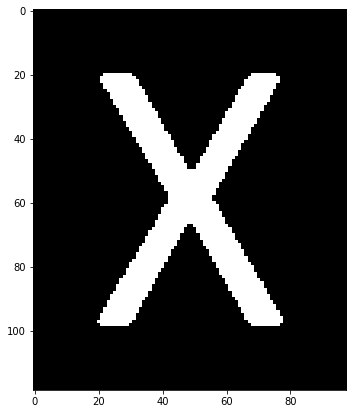

In [ ]:
# Lectura de una imagen X
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = ImageLoad('letras/char_',1,3,echo='on')
implot = plt.imshow(img,cmap='gray')


loading image letras/char_02_043.png...


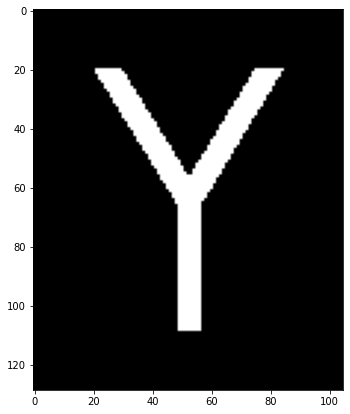

In [ ]:
# Lectura de una imagen Y
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = ImageLoad('letras/char_',2,43,echo='on')
implot = plt.imshow(img,cmap='gray')


loading image letras/char_03_043.png...


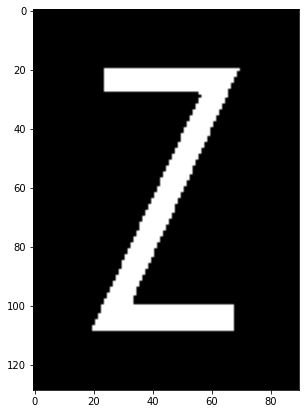

In [ ]:
# Lectura de una imagen Z
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = ImageLoad('letras/char_',3,43,echo='on')
implot = plt.imshow(img,cmap='gray')

loading image letras/char_04_043.png...


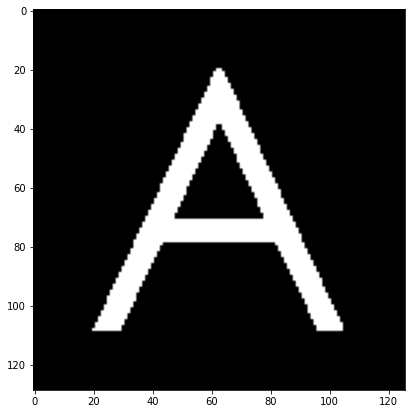

In [ ]:
# Lectura de una imagen A
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = ImageLoad('letras/char_',4,43,echo='on')
implot = plt.imshow(img,cmap='gray')

loading image letras/char_05_043.png...


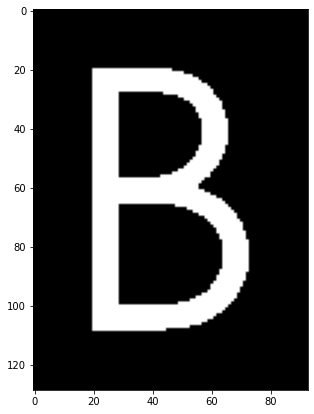

In [ ]:
# Lectura de una imagen B
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = ImageLoad('letras/char_',5,43,echo='on')
implot = plt.imshow(img,cmap='gray')

# 2. RONDAS DE EXPERIMENTOS

# I. PRIMERA RONDA DE EXPERIMENTOS

## A. Extracción de características

La función ```def AreaNormalizada() ```extrae la característica de área normalizada, definida como el número de pixeles de la letra (rellena, sin agujeros) dividido por el número de pixeles de la imagen. Esta característica es un número entre 0 y 1, es invariante al tamaño  y además invariante a la rotación.

Carácterística: área normalizada

In [ ]:
# La característica a extraer es el area normalizada, definida como el numero de
# pixeles de la letra (rellena, sin agujeros) dividido por el número de pixeles de la
# imagen. Esta característica es un número entre 0 y 1, es invariante al tamaño
# y además invariante a la rotación.

def AreaNormalizada(img,echo='off'):
  R = img>0.5                          # segmentacion, R ahora es una imagen binaria
  R = binary_fill_holes(R).astype(int) # imagen con relleno de agujeros
  CharArea = np.sum(R)                 # CharArea: area de la letra en pixeles
  ImgArea  = R.shape[0]*R.shape[1]     # ImgArea: numero de pixeles de la imagen
  AreaN = CharArea/ImgArea             # AreaN: area normalizada
  if echo=='on':
    implot = plt.imshow(R,cmap='gray')
    print('Area normalizada = '+str(AreaN))
  return AreaN

Ejemplo del área normalizada para la letra B




loading image letras/char_05_013.png...
Area normalizada = 0.37121096725057123


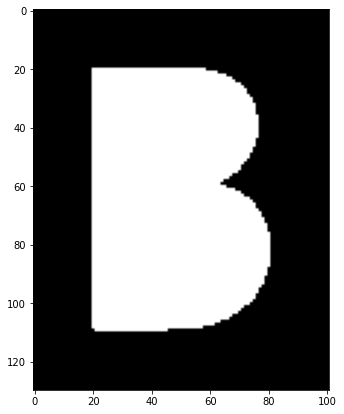

In [ ]:
# Ejemplo de característica área normalizada para una letra B

imgB = ImageLoad('letras/char_',5,13,echo='on')
AreaNB = AreaNormalizada(imgB,echo='on')

In [ ]:
# Extracción del rectángulo recubridor mínimo para una imagen
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return img[ymin:ymax+1, xmin:xmax+1]

Ejemplo de rectángulo recubridor mínimo para la letra B

Area normalizada = 0.8877959927140255


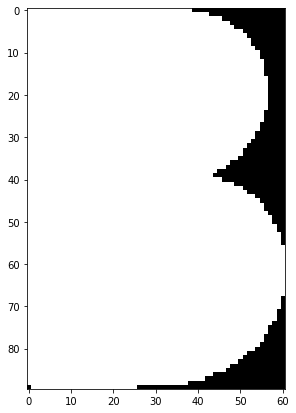

In [ ]:
AreaNB = AreaNormalizada(bbox2(imgB),echo='on')

In [ ]:
# Extracción de la característica AreaNormalizada en todas las imágenes 'X', 'Y', 'Z', 'A', 'B'

K = 5  # número de clases
N =75 # número de imágenes por clase

X = np.zeros((N,K))

for j in range(K):     # para cada clase
  for i in range(N):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1,echo='on')
    # Extracción de característica
    X[i,j] = AreaNormalizada(bbox2(img))

Definición de conjuntos de train y test.

*   Training: primeras 75 letras de cada clase
*   Training: últimas 25 letras de cada clase

In [ ]:
# Definición de conjuntos de training y testing
letters_train = dict(zip(['X', 'Y', 'Z', 'A', 'B'], [X[0:75, i] for i in range(0, X.shape[1])])) # Training: las primeras 75 letras de cada clase
letters_test = dict(zip(['X', 'Y', 'Z', 'A', 'B'], [X[75:100, i] for i in range(0, X.shape[1])])) # Testing: las ultimas 25 letras de cada clase

# Estadisticas train
statistics_train = {}
for letter in letters_train.keys():
    statistics_train[letter] = {'max':np.max(letters_train[letter]),
                                'min':np.min(letters_train[letter]),
                                'mean':np.mean(letters_train[letter]),
                              'median':np.median(letters_train[letter])}


In [ ]:
print("Estadísticas de la característica extraída en el Training para las letras 'X', 'Y', 'Z', 'A', 'B'")
statistics_train

Estadísticas de la característica extraída en el Training para las letras 'X', 'Y', 'Z', 'A', 'B'


{'A': {'max': 0.8323529411764706,
  'mean': 0.44215743034394517,
  'median': 0.43407407407407406,
  'min': 0.2692841139443081},
 'B': {'max': 0.9171391988293397,
  'mean': 0.8113165867282387,
  'median': 0.8219339622641509,
  'min': 0.66949423815621},
 'X': {'max': 0.6114894360048891,
  'mean': 0.3726632237489881,
  'median': 0.34156378600823045,
  'min': 0.22493606138107416},
 'Y': {'max': 0.47316176470588234,
  'mean': 0.29787837087292135,
  'median': 0.2694422623723488,
  'min': 0.204776857931297},
 'Z': {'max': 0.6967243975903614,
  'mean': 0.41635389686175456,
  'median': 0.3784313725490196,
  'min': 0.24580932425353588}}

Boxplot para letras del conjunto de train

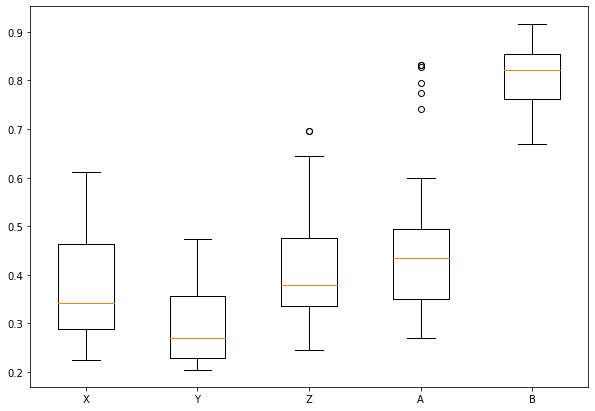

In [ ]:
df_letters = pd.DataFrame(letters_train) # dataframe con letras de conjunto de train
plt.boxplot(df_letters.T)
x = [1, 2, 3, 4, 5]
labels = statistics_train.keys()
plt.xticks(x, labels, rotation ='horizontal');

Distribución de frecuencias por clase para letras del conjunto de train

0 = 'A'

1 = 'B'

2 = 'X'

3 = 'Y'

4 = 'Z'

Histograma Train Experimento 1


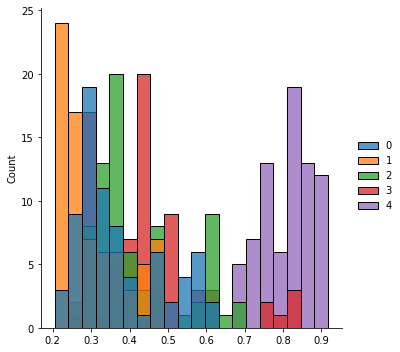

In [ ]:
print("Histograma Train Experimento 1")
sns.displot([X[0:75, i] for i in range(0, X.shape[1])],bins=20);

## B. Clasificación

In [ ]:
def reconocedor1(img, dic_letras):
  descriptor_an = AreaNormalizada(bbox2(img))
  # Para cada letra calcular la distancia aabssoluta a entre el descriptor de area normalizadaa para la letra entrante
  # Y cada una de las medianas de los conjuntos de las letras vistas urante entrenamiento
  diffs_medians = [np.abs(descriptor_an - dic_letras[letra]['median']) for letra in dic_letras.keys()]
  pred = np.argmin(diffs_medians) + 1 # Obtener el indice de la diferencia menor, este indice es el indice de la letra que hay que predecir

  return pred


In [ ]:
# clasificación
K = 5  # número de clases
X = np.zeros((25,K))

conf_matrix = np.zeros((K,K)) # Matriz de 5x5, csad fila y columna representa una clase

for j in range(K):     # para cada clase
  for i in range(75,100,1):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1, echo = 'off')
    # Extracción de característica
    conf_matrix[j, reconocedor1(img, statistics_train)-1] += 1

## C. Evaluación

In [ ]:
conf_matrix

array([[ 5.,  6.,  7.,  5.,  2.],
       [ 0., 18.,  0.,  7.,  0.],
       [ 3.,  6.,  9.,  2.,  5.],
       [ 1.,  0., 11.,  9.,  4.],
       [ 0.,  0.,  0.,  6., 19.]])

In [ ]:
acc1 =np.sum(conf_matrix.diagonal())/(25*5)*100

In [ ]:
print('Accuracy = '+ str(acc1) +'%')

Accuracy = 48.0%


# II. SEGUNDA RONDA DE EXPERIMENTOS

## A. Extracción de características



Carácterística: extracción de contornos

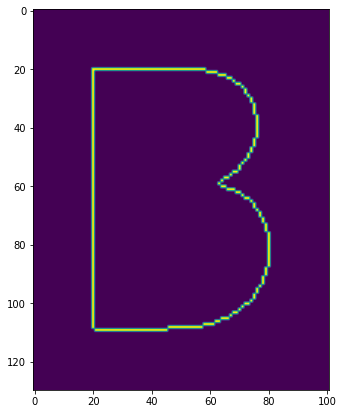

In [ ]:

# Read in the image as grayscale - Note the 0 flag
#im = cv2.fromarray(imgB)

# Run findContours - Note the RETR_EXTERNAL flag
# Also, we want to find the best contour possible with CHAIN_APPROX_NONE
imgray = np.expand_dims(imgB, 2)#cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0.5, 1, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(imgB.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Create an output of all zeroes that has the same shape as the input
# image
out = np.zeros_like(imgB)

# On this output, draw all of the contours that we have detected
# in white, and set the thickness to be 3 pixels
cv2.drawContours(out, contours, -1, 1, 1)

# Spawn new windows that shows us the letter and the detected contour
#plt.imshow(imgB)
plt.imshow(out)

In [ ]:
perimetro = np.sum(out)
perimetro

273

Cálculo de la redondez

In [ ]:
CharArea = np.sum(thresh)
roundness = (4*CharArea*np.pi)/(perimetro**2)
roundness

0.49773814291870655

In [ ]:
def get_roundness(img):
  imgray = np.expand_dims(img, 2)#cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
  imgray = imgray.astype(np.uint8)
  ret, thresh = cv2.threshold(imgray, 0.5, 1, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # Create an output of all zeroes that has the same shape as the input
  # image
  out = np.zeros_like(img)
  cv2.drawContours(out, contours, -1, 1, 1)

  #R = imgB>0.5                          # segmentacion, R ahora es una imagen binaria
  perimetro = np.sum(out)
  thresh = binary_fill_holes(thresh).astype(int) # imagen con relleno de agujeros
  CharArea = np.sum(thresh)                 # area de la letra en pixeles
  roundness = (4*CharArea*np.pi)/(perimetro**2)
  return roundness

In [ ]:
# Extracción de la característica redondez en todas las imágenes

K = 5  # número de clases
N =75 # número de imágenes por clase

X = np.zeros((N,K))

for j in range(K):     # para cada clase
  for i in range(N):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1)
    # Extracción de característica
    X[i,j] = get_roundness(img)

In [ ]:
letters_train = dict(zip(['X', 'Y', 'Z', 'A', 'B'], [X[0:75, i] for i in range(0, X.shape[1])]))
letters_test = dict(zip(['X', 'Y', 'Z', 'A', 'B'], [X[75:100, i] for i in range(0, X.shape[1])]))

# Estadisticas train
statistics_train = {}
for letter in letters_train.keys():
  statistics_train[letter] = {'max':np.max(letters_train[letter]),
                              'min':np.min(letters_train[letter]),
                              'mean':np.mean(letters_train[letter]),
                              'median': np.median(letters_train[letter])}

In [ ]:

statistics_train

{'A': {'max': 0.6367720982514278,
  'mean': 0.39204935787536066,
  'median': 0.36852071164547306,
  'min': 0.2288360933936374},
 'B': {'max': 0.915070401964598,
  'mean': 0.7421751267793782,
  'median': 0.7953800776027353,
  'min': 0.3250196990418773},
 'X': {'max': 0.39845904577617736,
  'mean': 0.22424056581846627,
  'median': 0.2008599722620079,
  'min': 0.09367865568709388},
 'Y': {'max': 0.4743816090945698,
  'mean': 0.26451349975487637,
  'median': 0.2434080586300962,
  'min': 0.11971867837898605},
 'Z': {'max': 0.4242364856424051,
  'mean': 0.2053686698575124,
  'median': 0.17925558082247645,
  'min': 0.10547935690557515}}

Boxplot para letras del conjunto de train

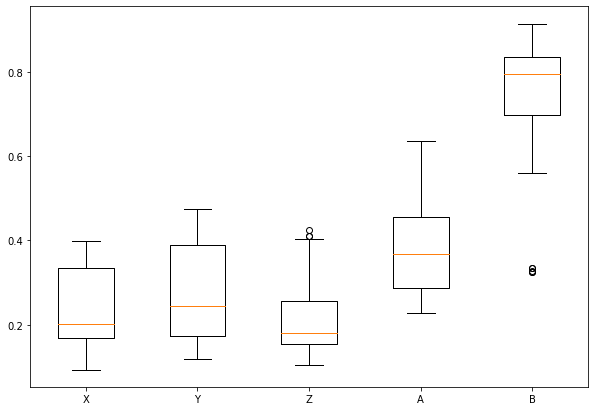

In [ ]:
df_letters = pd.DataFrame(letters_train) # dataframe con letras de conjunto de train
plt.boxplot(df_letters.T)
x = [1, 2, 3, 4, 5]
labels = statistics_train.keys()
plt.xticks(x, labels, rotation ='horizontal');

Distribución de frecuencias por clase para letras del conjunto de train

0 = 'A'

1 = 'B'

2 = 'X'

3 = 'Y'

4 = 'Z'

Histograma Train Experimento 2


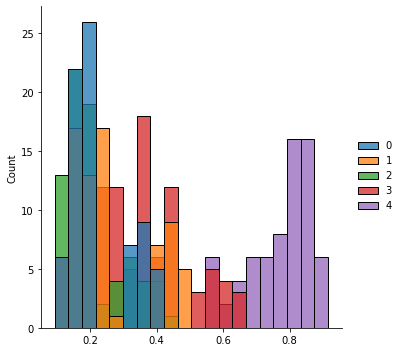

In [ ]:
print("Histograma Train Experimento 2")
sns.displot([X[0:75, i] for i in range(0, X.shape[1])],bins=20);


## B. Clasificación

In [ ]:
def reconocedor2(img, dic_letras):
  descriptor_an = get_roundness(img)
  # Para cada letra calcular la distancia abssoluta entre el descriptor de area normalizadaa para la letra entrante
  # Y cada una de las medianas de los conjuntos de las letras vistas urante entrenamiento
  diffs_medians = [np.abs(descriptor_an - dic_letras[letra]['median']) for letra in dic_letras.keys()]
  pred = np.argmin(diffs_medians) + 1 # Obtener el indice de la diferencia menor, este indice es el indice de la letra que hay que predecir

  return pred


In [ ]:
# clasificación
K = 5  # número de clases
X = np.zeros((25,K)) # 25: letras conjunto de test

conf_matrix = np.zeros((K,K)) # Matriz de 5x5, csad fila y columna representa una clase

for j in range(K):     # para cada clase
  for i in range(75,100,1):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1, echo = 'off')
    # Extracción de característica
    conf_matrix[j, reconocedor2(img, statistics_train)-1] += 1

## C. Evaluación

In [ ]:
conf_matrix

array([[12.,  0.,  6.,  7.,  0.],
       [ 3.,  9.,  6.,  7.,  0.],
       [ 1.,  0., 17.,  7.,  0.],
       [ 0.,  0.,  6., 15.,  4.],
       [ 0.,  0.,  0.,  7., 18.]])

In [ ]:
acc2 = np.sum(conf_matrix.diagonal())/(25*5)*100

In [ ]:
print('Accuracy = '+ str(acc2) +'%')

Accuracy = 56.8%




---

# III. TERCERA RONDA DE EXPERIMENTOS


## A. Extracción de características

In [ ]:
def center_of_mass(image):
    x_sum = np.sum([np.sum(np.flatnonzero(x)) for x in image])
    y_sum = np.sum([np.sum(np.flatnonzero(x)) for x in np.rot90(image)])
    mass = np.sum(image)
    return (x_sum / mass, y_sum / mass)

def get_centerPixels(img, window_size = 20):
  #H, W = img.shape[0], img.shape[1]
  center = center_of_mass(img)
  horizontal_lim_inf = int(center[1]-window_size)
  horizontal_lim_sup = int(center[1]+window_size)
  vertical_lim_inf = int(center[0]-window_size)
  vertical_lim_sup = int(center[0]+window_size)

  # Cantidad de pixeles en el cuadrante de 20x20 rodeando al centro de masa
  return np.mean(img[horizontal_lim_inf:horizontal_lim_sup, vertical_lim_inf:vertical_lim_sup])

def reconocedor3(img, dic_letras):
  descriptor_an = get_centerPixels(img, 15)/AreaNormalizada(bbox2(img)) # Este es el descriptor
  # Para cada letra calcular la distancia abssoluta entre el descriptor de area normalizada para la letra entrante
  # Y cada una de las medianas de los conjuntos de las letras vistas durante entrenamiento
  diffs_medians = [np.abs(descriptor_an - dic_letras[letra]['median']) for letra in dic_letras.keys()]
  pred = np.argmin(diffs_medians) + 1 # Obtener el indice de la diferencia menor, este indice es el indice de la letra que hay que predecir

  return pred

loading image letras/char_05_043.png...


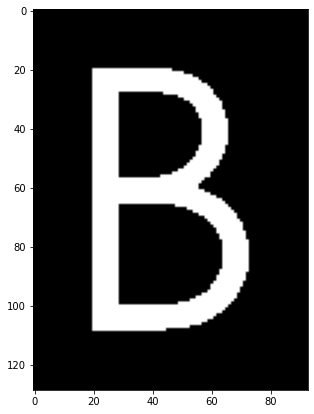

In [ ]:
# Lectura de una imagen B
fig    = plt.figure()
ax     = fig.add_subplot(111)
img    = ImageLoad('letras/char_',5,43,echo='on')
implot = plt.imshow(img,cmap='gray')

In [ ]:
#H, W = img.shape[0], img.shape[1]
window_size =15
center = center_of_mass(img)
horizontal_lim_inf = int(center[1]-window_size)
horizontal_lim_sup = int(center[1]+window_size)
vertical_lim_inf = int(center[0]-window_size)
vertical_lim_sup = int(center[0]+window_size)
# Cantidad de pixeles en el cuadrante de 20x20 rodeando al centro de masa
np.sum(img[horizontal_lim_inf:horizontal_lim_sup, vertical_lim_inf:vertical_lim_sup])


391

Pixeles centrales de la imagen

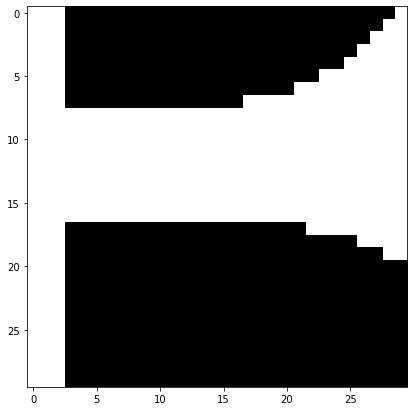

In [ ]:
plt.imshow(img[horizontal_lim_inf:horizontal_lim_sup, vertical_lim_inf:vertical_lim_sup], cmap ='gray')

In [ ]:
# Extracción de la característica pixeles centraless

K = 5  # número de clases
N =75 # número de imágenes por clase

X = np.zeros((N,K))

for j in range(K):     # para cada clase
  for i in range(N):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1)
    # Extracción de característica
    X[i,j] = get_centerPixels(img, 15)/AreaNormalizada(bbox2(img)) # Este es el descriptor

In [ ]:
letters_train = dict(zip(['X', 'Y', 'Z', 'A', 'B'], [X[0:75, i] for i in range(0, X.shape[1])]))
letters_test = dict(zip(['X', 'Y', 'Z', 'A', 'B'], [X[75:100, i] for i in range(0, X.shape[1])]))

# Estadisticas train
statistics_train = {}
for letter in letters_train.keys():
  statistics_train[letter] = {'max':np.max(letters_train[letter]),
                              'min':np.min(letters_train[letter]),
                              'mean':np.mean(letters_train[letter]),
                              'median': np.median(letters_train[letter])}
                              #'1st quartile': np.quantile(letters_train[letter], .25), '3rd quantile': np.quantile(letters_train[letter], .75)}

In [ ]:
statistics_train

{'A': {'max': 1.7371161296002817,
  'mean': 1.1897084175969639,
  'median': 1.1331136113952345,
  'min': 0.8496240049888119},
 'B': {'max': 1.0470954356846474,
  'mean': 0.5308762574773052,
  'median': 0.4788102306462663,
  'min': 0.12378386993943259},
 'X': {'max': 2.689855072463768,
  'mean': 1.9571216484312728,
  'median': 1.9418181818181819,
  'min': 1.3401898734177216},
 'Y': {'max': 2.8866109045848822,
  'mean': 2.1410950290680466,
  'median': 2.1583006535947713,
  'min': 1.3177307366638442},
 'Z': {'max': 1.9482471076184238,
  'mean': 1.2168745437954054,
  'median': 1.195263509006004,
  'min': 0.7246716981132076}}

Boxplot para letras del conjunto de train

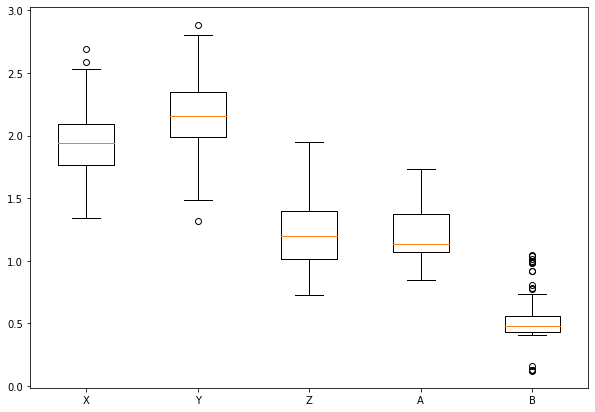

In [ ]:
df_letters = pd.DataFrame(letters_train) # dataframe con letras de conjunto de train
plt.boxplot(df_letters.T)
x = [1, 2, 3, 4, 5]
labels = statistics_train.keys()
plt.xticks(x, labels, rotation ='horizontal');


Distribución de frecuencias por clase para letras del conjunto de train

0 = 'A'

1 = 'B'

2 = 'X'

3 = 'Y'

4 = 'Z'

Histograma Train Experimento 3


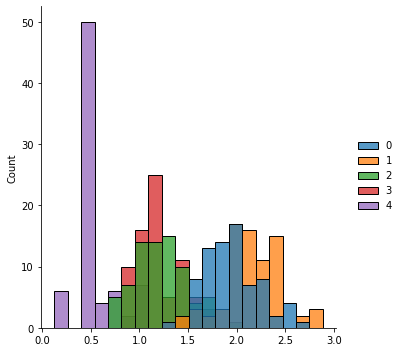

In [ ]:
print("Histograma Train Experimento 3")
sns.displot([X[0:75, i] for i in range(0, X.shape[1])],bins=20);


## B. Clasificación

In [ ]:
# clasificación
K = 5  # número de clases
X = np.zeros((75,K))

conf_matrix = np.zeros((K,K)) # Matriz de 5x5, csad fila y columna representa una clase

for j in range(K):     # para cada clase
  for i in range(75):#range(76,100,1):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1, echo = 'off')
    # Extracción de característica
    conf_matrix[j, reconocedor3(img, statistics_train)-1] += 1

## C. Evaluación

In [ ]:
conf_matrix

array([[46., 25.,  4.,  0.,  0.],
       [22., 47.,  6.,  0.,  0.],
       [ 7.,  0., 35., 28.,  5.],
       [ 3.,  0., 25., 47.,  0.],
       [ 0.,  0.,  0.,  9., 66.]])

In [ ]:
acc3 = np.sum(conf_matrix.diagonal())/(75*5)*100

In [ ]:
print('Accuracy = '+ str(acc3) +'%')

Accuracy = 64.26666666666667%


In [ ]:
# Extracción de la característica AreaNormalizada en todas las imágenes

K = 5  # número de clases
N =75 # número de imágenes por clase

X = np.zeros((N,K))

for j in range(K):     # para cada clase
  print(f"letra {['X', 'Y', 'Z', 'A', 'B'][j]}")
  for i in range(N):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1)
    plt.imshow(img)
    plt.show()
    # Extracción de característica
    #X[i,j] = get_centerPixels(img, 15)/AreaNormalizada(bbox2(img)) # Este es el descriptor

# IV. CUARTA RONDA DE EXPERIMENTOS (definitiva)

Esta ronda de experimentos se va a centrar en la construcción de un vector de atributos que sea rico en información y contenga la información de diferentes características geométricas para las imágenes. Los elementos de este vector van a ser:


1.   __Simetría en el eje vertical:__
  * Tomar ancho de la imagen y dividirlo en 2.
  * Restar pixel-wise las partes correspondientes a la primera mitad y a la segunda mitad flipeada.
  * Calcular la media de las diferencias absolutas.
2.  __Simetría en el eje horizontal:__ Idem al caso anterior solo que con simetría horizontal.
3.  __Área normalizada__ (descriptor_1 desarrollado en los experimentos anteriores)
4.  __Redondez__ (descriptor_3 desarrollado en los experimentos anteriores)
5.  __Pixeles que rodean al centro de masa * Área normalizada__ (desarrollada en los experimentos anteriores)


Para la tarea de __clasificación se implementará KNN__.

## A. Extracción de características

In [ ]:
def reconocedor3(img):
  pass


def vertical_symmetry(img):
  img = np.where(img>.5, 1, 0)
  h, w = img.shape
  if h%2 != 0:
    mitad_inferior = img[h//2+1:, :]
  else:
    mitad_inferior = img[h//2:, :]

  mitad_superior = img[:h//2, :]

  flipped_superior = cv2.flip(mitad_superior, 0)
  return 1-np.sum(np.abs(flipped_superior - mitad_inferior))/(flipped_superior.shape[0]* flipped_superior.shape[1])


def horizontal_symmetry(img):
  """
  Retorna el grado de simetría en el eje horizontal de la imagen. Normalizado en [0,1] donde un valor de 1 quiere decir que es perfectamente
  simétrica con respecto al eje horizontal y 0 lo opuesto.
  """
  img = np.where(img>.5, 1, 0)
  h, w = img.shape
  if w%2 != 0:
    mitad_derecha = img[:, w//2+1:]
  else:
    mitad_derecha = img[:, w//2:]

  mitad_izquierda = img[:, :w//2]

  flipped_derecha = cv2.flip(mitad_derecha, 1)

  #plt.imshow(flipped_derecha, cmap = 'gray')
  #plt.show()

  #plt.imshow(mitad_izquierda, cmap = 'gray')
  #plt.show()

  # divido por el area para normalizar el resultado a [0,1]
  return 1-np.sum(np.abs(flipped_derecha - mitad_izquierda))/(flipped_derecha.shape[0]*flipped_derecha.shape[1])

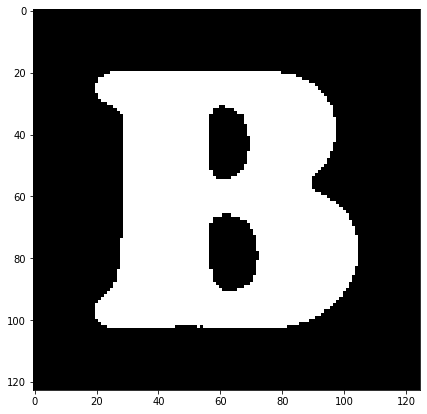

In [ ]:
plt.imshow(np.where(img>0.5, 1, 0), cmap = 'gray')

In [ ]:
dict_letras = {1:'A', 2:'B', 3:'X', 4:'Y', 5:'Z'}

In [ ]:

K = 5  # número de clases
N =75 # número de imágenes por clase

X = np.zeros((N,K))
df = pd.DataFrame()

for j in range(K):     # para cada clase
  for i in range(N):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1)
    img = np.where(img > .5, 1, 0)
    # Extracción de característica
    #X[i,j] = (vertical_symmetry(img), horizontal_symmetry(img))
    df = df.append({'deg_vertical_sym':vertical_symmetry(img), 'deg_horizontal_sym':horizontal_symmetry(img), 'letter':dict_letras[j+1]}, ignore_index=True)

Grados de simetría horizontal y vertical

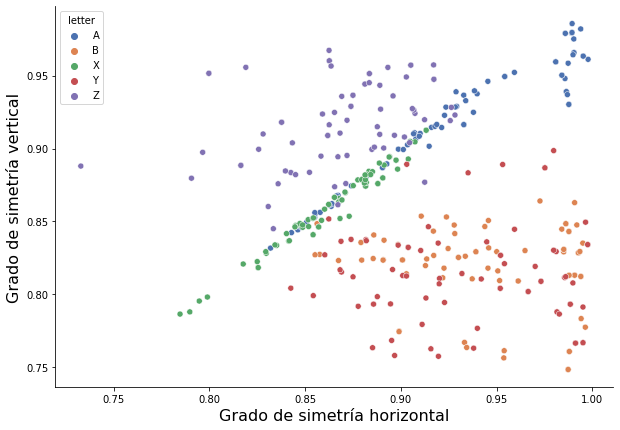

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)

sns.scatterplot(x = 'deg_horizontal_sym', y = 'deg_vertical_sym', data = df, hue = 'letter', palette = 'deep')
plt.xlabel('Grado de simetría horizontal', fontsize = 16)
plt.ylabel('Grado de simetría vertical', fontsize = 16)
sns.despine();

### Conformación del vector de atributos
Con los 5 descriptores



In [ ]:

K = 5  # número de clases
N =75 # número de imágenes por clase

X = np.zeros((N,K))
df = pd.DataFrame()

for j in range(K):     # para cada clase
  for i in range(N):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1)
    #img = np.where(img > .5, 1, 0)
    img = bbox2(img)
    # Extracción de característica
    #X[i,j] = (vertical_symmetry(img), horizontal_symmetry(img))
    df = df.append({'deg_vertical_sym':vertical_symmetry(img),
                    'deg_horizontal_sym':horizontal_symmetry(img),
                    'descriptor_1':AreaNormalizada(img),
                    'redondez': get_roundness(img),
                    'descriptor_3' :get_centerPixels(img, 5)*AreaNormalizada(img),
                    'letter':j+1}, ignore_index=True)

Grilla de dimensión 5x5 con los pares de descriptores creados anteriormente

In [ ]:
df.letter = df.letter.astype(int)

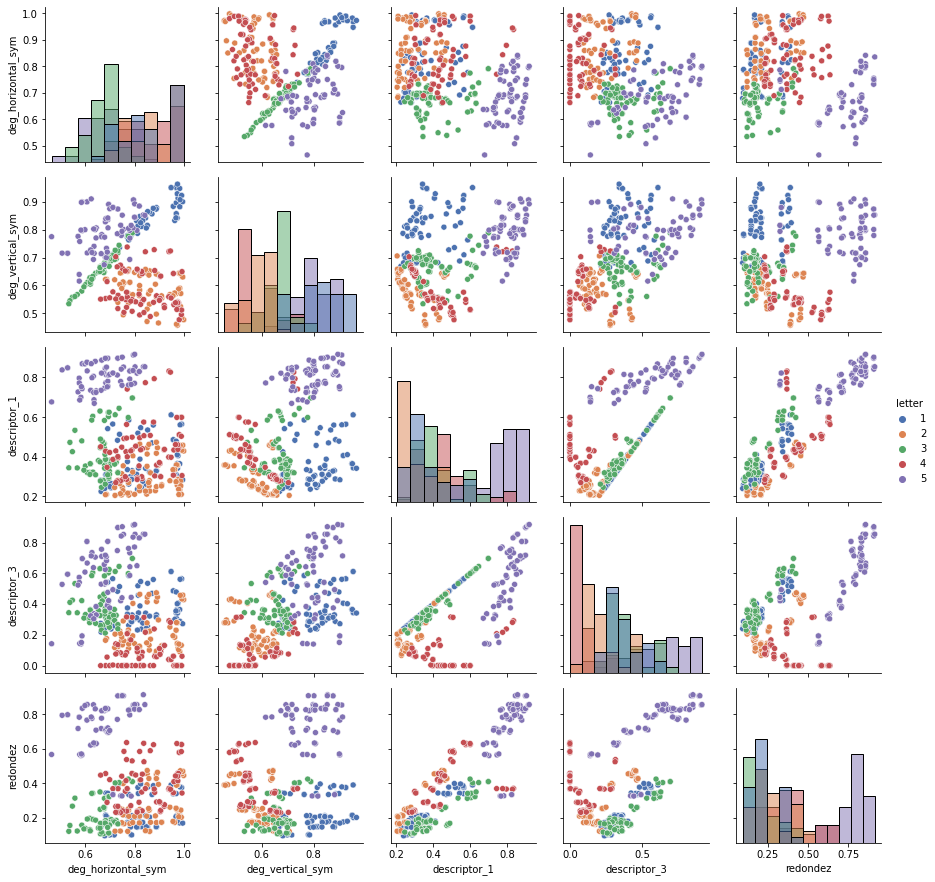

In [ ]:
g = sns.PairGrid(data = df, hue ='letter', palette='deep')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

## B. Clasificación

In [ ]:
def reconocedor4(img, data = df, k = 5):
  """
  Este va a ser simplemente KNN.
  """
  img = bbox2(img)
  descriptor_vect =np.array([horizontal_symmetry(img),vertical_symmetry(img), AreaNormalizada(img), get_centerPixels(img,5)*AreaNormalizada(img), get_roundness(img)])
  distances = np.array([np.linalg.norm(train_example - descriptor_vect) for train_example in data.drop(columns = 'letter').values])

  k_nearest = data.iloc[distances.argsort()[:k]]['letter']
  mode = int(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=k_nearest))

  return mode

## C. Evaluación



### Train

In [ ]:
# clasificación
K = 5  # número de clases
X = np.zeros((75,K))

conf_matrix = np.zeros((K,K)) # Matriz de 5x5, cada fila y columna representa una clase

for j in range(K):     # para cada clase
  for i in range(75):#range(76,100,1):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1, echo = 'off')
    # Extracción de característica
    conf_matrix[j, reconocedor4(img, k = 10)-1] += 1

In [ ]:
print("Matriz de confusión de Train:" +'\n' ,
      conf_matrix)

Matriz de confusión de Train:
 [[65.  0. 10.  0.  0.]
 [ 1. 74.  0.  0.  0.]
 [ 2.  0. 73.  0.  0.]
 [ 0.  3.  0. 72.  0.]
 [ 0.  0.  0.  1. 74.]]


In [ ]:
accuracy4_train = np.sum(conf_matrix.diagonal())/(75*5)*100

In [ ]:
print('Accuracy Train: '+ str(accuracy4_train) +'%')

Accuracy Train: 95.46666666666667%


### Test

In [ ]:
# clasificación
K = 5  # número de clases
X = np.zeros((25,K))

conf_matrix = np.zeros((K,K)) # Matriz de 5x5, csad fila y columna representa una clase

for j in range(K):     # para cada clase
  for i in range(76,100,1):   # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1, echo = 'off')
    # Extracción de característica
    conf_matrix[j, reconocedor4(img, k = 10)-1] += 1

In [ ]:
print("Matriz de confusión de Test:" +'\n' ,
      conf_matrix)

Matriz de confusión de Test:
 [[20.  0.  4.  0.  0.]
 [ 5. 19.  0.  0.  0.]
 [ 0.  6. 18.  0.  0.]
 [ 0.  2.  0. 22.  0.]
 [ 0.  0.  6.  0. 18.]]


In [ ]:
accuracy4_test = np.sum(conf_matrix.diagonal())/(25*5)*100
print('Accuracy Test: '+ str(accuracy4_test) +'%')

Accuracy Test: 77.60000000000001%
